<a href="https://colab.research.google.com/github/pratyakshajha/project-dog-classification/blob/optimize-pytorch-model/dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks


We break the notebook into separate steps.  

* Step 0: Import Datasets
* Step 1: Detect Humans
* Step 2: Detect Dogs
* Step 3: Create a CNN to Classify Dog Breeds (from Scratch)
* Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)
* Step 5: Write your Algorithm
* Step 6: Test Your Algorithm

---

## Step 0: Import Datasets

In this step, the human and dog datasets are downloaded :
* [Dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). 

* [Human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  


In the code cells below, we download and untar the required data files and, save the file paths for both the human and dog dataset in the numpy arrays `human_files` and `dog_files`.

Dataset sources: 
 - Human Dataset: [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/#download) from University of Massachussets, Amherst.
 - Dog Dataset: [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/) from Stanford University.
 

In [8]:
# download the required data files

!wget -cq https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget -cq https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!git clone https://github.com/pratyakshajha/project-dog-classification.git

Cloning into 'project-dog-classification'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 89 (delta 49), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (89/89), done.


In [2]:
!wget -cq http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget -cq http://vis-www.cs.umass.edu/lfw/lfw.tgz
!git clone https://github.com/pratyakshajha/project-dog-classification.git

Cloning into 'project-dog-classification'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 89 (delta 49), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (89/89), done.


In [3]:
# untar the data files

!rm -r images || true
!tar xf images.tar

!rm -r lfw || true
!tar xzf lfw.tgz

!rm -r __MACOSX || true

rm: cannot remove 'images': No such file or directory
rm: cannot remove 'lfw': No such file or directory
rm: cannot remove '__MACOSX': No such file or directory


In [0]:
# all imports

import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt 
from tqdm import tqdm
from PIL import Image
from PIL import ImageFile
import os
from collections import OrderedDict
import time
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets

%matplotlib inline                               

In [7]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 0 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images is used.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we can see how to use this detector to find human faces in a sample image.

Number of faces detected: 2


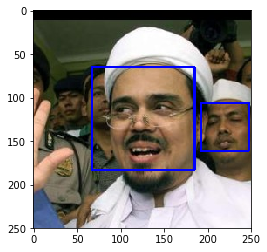

In [11]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('project-dog-classification/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessing the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  Our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [14]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

count = []
temp = 0
for file in tqdm(human_files_short):
  if face_detector(file):
    temp += 1
count.append(temp)    

temp = 0
for file in tqdm(dog_files_short):
  if face_detector(file):
    temp += 1
count.append(temp)   
    
print('\nPercentage of human face detected in the first 100 images:\nhuman_files:{}\tdog_files:{}'.format(count[0], count[1]))

100%|██████████| 100/100 [00:04<00:00, 20.55it/s]
0it [00:00, ?it/s]


Percentage of human face detected in the first 100 images:
human_files:100	dog_files:0


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [0]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
553433881it [00:05, 94219838.26it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, the function accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [0]:
def process_image(image):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))    
    
    return img

In [0]:
# Set PIL to be tolerant of image files that are truncated.
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Process image
    img = process_image(img_path) 
    img = torch.from_numpy(img).type(torch.FloatTensor) 
    img.unsqueeze_(0)
    img = img.cuda()

    # Predict top label
    probs = torch.exp(VGG16.forward(img)) 
    top_prob, top_lab = probs.topk(1)     
    
    return top_lab # predicted class index

### Writing a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas the `dog_detector` function below returns `True` if a dog is detected in an image (and `False` if not).

In [0]:
int(VGG16_predict('dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'))

252

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    pred = int(VGG16_predict(img_path))
    if 150 < pred <269:
      return True
    else:    
      return False 

### Assessing the Dog Detector

In [0]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

count = []
temp = 0
for file in tqdm(human_files_short):
  if dog_detector(file):
    temp += 1
count.append(temp)    

temp = 0
for file in tqdm(dog_files_short):
  if dog_detector(file):
    temp += 1
count.append(temp)   
    
print('\nPercentage of dogs detected in the first 100 images:\nhuman_files:{}\tdog_files:{}'.format(count[0], count[1]))

100%|██████████| 100/100 [00:03<00:00, 25.43it/s]


Percentage of dogs detected in the first 100 images:
human_files:0	dog_files:99


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, I create a CNN that classifies dog breeds and try to attain a test accuracy of at least 10%. 

The task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://github.com/pratyakshajha/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Brittany_02625.jpg?raw=1" width="100"> | <img src="https://github.com/pratyakshajha/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Welsh_springer_spaniel_08203.jpg?raw=1" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://github.com/pratyakshajha/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Curly-coated_retriever_03896.jpg?raw=1" width="200"> | <img src="https://github.com/pratyakshajha/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/American_water_spaniel_00648.jpg?raw=1" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black. The vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://github.com/pratyakshajha/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06457.jpg?raw=1" width="150"> | <img src="https://github.com/pratyakshajha/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06455.jpg?raw=1" width="240"> | <img src="https://github.com/pratyakshajha/deep-learning-v2-pytorch/blob/master/project-dog-classification/images/Labrador_retriever_06449.jpg?raw=1" width="220">

The random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

### Specify Data Loaders for the Dog Dataset

For preprocessing the data, several functions from `torch.transforms` module are used. The images are cropped and normalised according to imagenet dataset. This is necessary as the pre-trained models need input images to be of same dimensions and similar distribution as the images it was trained on.  The images were resized to be 224 by 224 pixels. Mean and standard deviation of `[0.485, 0.456, 0.406]` and `[0.229, 0.224, 0.225]` are applied.

The training data is also augmented, while the validation and testing data is only adjusted according to imagenet data. The augmentation that is added is of the form:


*   Rotation
*   Horizontally and Vertically flipped
*   Variation in brightness, contrast and saturation

In [0]:
### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# Transforms for the training and validation sets

data_transforms = {
    'train': transforms.Compose([        
        transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [0]:
dirs = {'train': 'dogImages/train', 
        'valid': 'dogImages/valid',
        'test': 'dogImages/test'}

image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}
loaders_scratch = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

### Model Architecture

Create a CNN to classify dog breed. I tried to replicate a smaller architecture similar to VGG model's architecture. The A configuration is used here. As the the depth of this configuration was too large for my colaboratory notebook to handle, I reduced the number of convolution filters in each layer. 

*VGG architecture:*

<img src="https://cdn-images-1.medium.com/max/1600/0*HREIJ1hjF7z4y9Dd.jpg" width="400">


*My architecture*


| Input Image        |
|-----------------------|
| (3x3) Convolutions - 16 |
| Relu Activation     |
| (2x2) Max Pooling     |
| (3x3) Convolutions  - 16|
| Relu Activation     |
| (2x2) Max Pooling     |
| (3x3) Convolutions - 32 |
| Relu Activation     |
| (2x2) Max Pooling     |
| (3x3) Convolutions - 64|
| Relu Activation     |
| (2x2) Max Pooling     |
| FC layer 1 - 4096  |
| FC layer 2  - 4096 |
| FC Layer 3  - 133  |
| Softmax  |

- Each convolution layer has filter size = (3x3), stride = (1x1) and padding = (1x1). The resulting tensors are of same size as that of input tensors. Multiple (3x3) convolution filters in a sequence work as higher order filters. At later layers, they help to indentify higher level features.
- Each convolution layer is followed by Relu activation. This adds non-linearity and helps in speeding up training.
- Relu activation is followed by Max Pool layer with kernel size = 2, stride = 2 and zero padding. This reduces the size of tensor by half. 
- Three fully connected layers are added for final classification along with dropout. Dropout adds some regularization in the network. 
- While training, Cross entropy loss is used. As this is a classification task, cross entropy works well as it fits according to the probability distribution of the data. Adam opimizer gives one of the best results as compared to other optimizers. Learning rate schedular is also added.  

In [0]:
# define the CNN architecture
class Net(nn.Module):
    ### choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 112x112x112 tensor)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        # convolutional layer (sees 56x56x56 tensor)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 28x28x28 tensor)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (512 * 14 * 14 -> 4096)
        self.fc1 = nn.Linear(64*14*14, 4096)
        # linear layer (4096 -> 4096)
        self.fc2 = nn.Linear(4096, 4096)
        # linear layer (4096 -> number of classes)
        self.fc3 = nn.Linear(4096, len(class_names))
        # dropout layer (p=0.5)
        self.dropout = nn.Dropout(0.5)        
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers        
        x = self.pool(F.relu(self.conv1(x)))       
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input, size is depth of image in previous maxpool*depth of convolution
        x = x.view(-1, 64*14*14)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc3(x)
        return x

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=133, bias=True)
  (dropout): Dropout(p=0.5)
)


### Specify Loss Function and Optimizer

Use the next code cell to specifies a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.


In [0]:
### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler_scratch = lr_scheduler.StepLR(optimizer_scratch, step_size = 8, gamma=0.1)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [0]:
all_losses = {'epoch': [],
              'train': [],
              'valid': [],
              'test': []
             }

all_accuracies = {'epoch': [],
                  'train': [],
                  'valid': [],
                  'test': []
             }

In [0]:
def print_current_time():
  # Display time in IST(UTC+5:30)
  hours, mins, secs = str(datetime.datetime.now().time())[:-8].split(':')
  hours, mins, secs = int(hours), int(mins), int(secs)

  if (mins+30)<60:
    hours = hours+5 
    mins=mins+30 
  else:
    hours = hours+6 
    mins = (mins+30) - 60
    
  print('Current time - {}:{}:{}'.format(hours, mins, secs)) 

In [0]:
# the following import is required for training to be robust to truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    print_current_time()       
    
    for epoch in range(1, n_epochs+1):
        all_losses['epoch'].append(epoch)
        all_accuracies['epoch'].append(epoch)
        start_time = time.time()
        print('-'*11)
        print('Epoch: {}'.format(epoch))
       
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_running_corrects = 0
        valid_running_corrects = 0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders_scratch['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                                
            # clear the gradients of all optimized variables
            optimizer_scratch.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model_scratch(data)
            _, preds = torch.max(outputs, 1)
            # calculate the batch loss
            loss = criterion_scratch(outputs, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer_scratch.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            train_running_corrects += torch.sum(preds == target.data)   
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders_scratch['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model_scratch(data)
            _, preds = torch.max(outputs, 1)
            # calculate the batch loss
            loss = criterion_scratch(outputs, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            valid_running_corrects += torch.sum(preds == target.data)
            
        # calculate average losses and accuracies
        train_loss = train_loss/len(loaders_scratch['train'].dataset)
        all_losses['train'].append(train_loss)
        valid_loss = valid_loss/len(loaders_scratch['valid'].dataset)
        all_losses['valid'].append(valid_loss)

        train_acc = train_running_corrects.double()/len(loaders_scratch['train'].dataset)
        all_accuracies['train'].append(train_acc)
        valid_acc = valid_running_corrects.double()/len(loaders_scratch['valid'].dataset)
        all_accuracies['valid'].append(valid_acc)
        time_epoch = time.time() - start_time

            
        # print training/validation statistics 
        print('Training Loss: {:.6f} \tValidation Loss: {:.6f}\tTime: {:.0f}m {:.0f}s'.format(             
            train_loss,
            valid_loss,
            time_epoch // 60, time_epoch % 60
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model_scratch.state_dict(), 'model_scratch.pt')
          valid_loss_min = valid_loss  
          
        # every 5 epochs print current time
        if epoch%5 == 0:
          print('*'*11)
          print_current_time()
          print('*'*11)          
        
    print()
            
    # return trained model
    return model


# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Current time - 18:56:3
-----------
Epoch: 1
Training Loss: 4.882817 	Validation Loss: 4.863901	Time: 4m 52s
Validation loss decreased (inf --> 4.863901).  Saving model ...
-----------
Epoch: 2
Training Loss: 4.863441 	Validation Loss: 4.821417	Time: 4m 50s
Validation loss decreased (4.863901 --> 4.821417).  Saving model ...
-----------
Epoch: 3
Training Loss: 4.748388 	Validation Loss: 4.590000	Time: 4m 47s
Validation loss decreased (4.821417 --> 4.590000).  Saving model ...
-----------
Epoch: 4
Training Loss: 4.621376 	Validation Loss: 4.493894	Time: 4m 47s
Validation loss decreased (4.590000 --> 4.493894).  Saving model ...
-----------
Epoch: 5
Training Loss: 4.573231 	Validation Loss: 4.434343	Time: 4m 49s
Validation loss decreased (4.493894 --> 4.434343).  Saving model ...
***********
Current time - 19:20:4
***********
-----------
Epoch: 6
Training Loss: 4.542214 	Validation Loss: 4.417711	Time: 4m 51s
Validation loss decreased (4.434343 --> 4.417711).  Saving model ...
-----------

### Test the Model

Try out your model on the test dataset of dog images. 

In [0]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.832080


Test Accuracy: 11% (93/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

Using transfer learning to create a CNN that can identify dog breed from images.  

### Specify Data Loaders for the Dog Dataset


In [0]:
### Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# Transforms for the training and validation sets

data_transforms = {
    'train': transforms.Compose([        
        transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])
}

In [0]:
dirs = {'train': 'dogImages/train', 
        'valid': 'dogImages/valid',
        'test': 'dogImages/test'}

image_datasets = {x: datasets.ImageFolder(dirs[x],   transform=data_transforms[x]) for x in ['train', 'valid', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) 
                              for x in ['train', 'valid', 'test']}

class_names = image_datasets['train'].classes

### Model Architecture

Use transfer learning to create a CNN to classify dog breed. 

Densenet model is used as the pretrained model here because:


*   It has good performance on imagenet, only after Inception model. 
*   It uses a lot less number of parameters.
*   It trains faster.
*   The size of model created is not very large. (~160Mb) This will help when the model is finally deployed on a server for the app. 
*    Similar accuracy can be achieved with densenet121 model, which has lesser layers. The size for this one is around 30Mb.

The classifier layers of the model is replaced by two fully connected layers. The first one has Relu activation while second is connected to log of softmax as output layer. 




In [0]:
## Specify model architecture 
# Load the pretrained model from pytorch
model_transfer = models.densenet161(pretrained=True)

if use_cuda:
    model_transfer = model_transfer.cuda()
    
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(model_transfer.classifier.in_features, model_transfer.classifier.out_features)),
                          ('relu', nn.ReLU()),                          
                          ('fc2', nn.Linear(model_transfer.classifier.out_features, len(class_names))),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))  

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
model_transfer.classifier = classifier

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
115730790it [00:01, 90054928.91it/s]


### Specify Loss Function and Optimizer

In [0]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler_transfer = lr_scheduler.StepLR(optimizer_transfer, step_size = 3, gamma=0.1)

### Train and Validate the Model

Train and validate model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [0]:
all_losses = {'epoch': [],
              'train': [],
              'valid': [],
              'test': []
             }

all_accuracies = {'epoch': [],
                  'train': [],
                  'valid': [],
                  'test': []
             }

In [0]:
def print_current_time():
  
  hours, mins, secs = str(datetime.datetime.now().time())[:-8].split(':')
  hours, mins, secs = int(hours), int(mins), int(secs)

  if (mins+30)<60:
    hours = hours+5 
    mins=mins+30 
  else:
    hours = hours+6 
    mins = (mins+30) - 60
    
  if hours>24:
    hours = hours - 24
    
  print('Current time - {}:{}:{}'.format(hours, mins, secs)) 

In [0]:
# train the model

# number of epochs to train the model
n_epochs = 10

model_transfer.cuda()
valid_loss_min = np.Inf # track change in validation loss
print_current_time()

for epoch in range(1, n_epochs+1):    
    all_losses['epoch'].append(epoch)
    all_accuracies['epoch'].append(epoch)
    start_time = time.time()
    print('-'*11)
    print('Epoch: {}'.format(epoch))

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    train_running_corrects = 0
    valid_running_corrects = 0
    
    ###################
    # train the model #
    ###################
    model_transfer.train()
    for inputs, target in dataloaders['train']:
        # move tensors to GPU if CUDA is available
        inputs, target = inputs.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_transfer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_transfer(inputs)
        _, preds = torch.max(outputs, 1)
        # calculate the batch loss
        loss = criterion_transfer(outputs, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_transfer.step()
        # update training loss
        train_loss += loss.item()*inputs.size(0)
        train_running_corrects += torch.sum(preds == target.data)        
        
    ######################    
    # validate the model #
    ######################
    model_transfer.eval()
    for inputs, target in dataloaders['valid']:
        # move tensors to GPU if CUDA is available
        inputs, target = inputs.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model_transfer(inputs)
        _, preds = torch.max(outputs, 1)
        # calculate the batch loss
        loss = criterion_transfer(outputs, target)
        # update average validation loss 
        valid_loss += loss.item()*inputs.size(0)
        valid_running_corrects += torch.sum(preds == target.data)
    
    # calculate average losses and accuracies
    train_loss = train_loss/len(dataloaders['train'].dataset)
    all_losses['train'].append(train_loss)
    valid_loss = valid_loss/len(dataloaders['valid'].dataset)
    all_losses['valid'].append(valid_loss)
    
    train_acc = train_running_corrects.double()/len(dataloaders['train'].dataset)
    all_accuracies['train'].append(train_acc)
    valid_acc = valid_running_corrects.double()/len(dataloaders['valid'].dataset)
    all_accuracies['valid'].append(valid_acc)
    time_epoch = time.time() - start_time
        
    # print training/validation statistics 
    print('Training Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    print('Training Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        train_acc, valid_acc))
    print_current_time()
    print('Epoch Time: {:.0f}m {:.0f}s'.format(
              time_epoch // 60, time_epoch % 60))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model_transfer.state_dict(), 'model_transfer.pth')
        valid_loss_min = valid_loss       
        
    print()

Current time - 21:29:5
-----------
Epoch: 1
Training Loss: 3.382925 	Validation Loss: 1.389189
Training Accuracy: 0.253743 	Validation Accuracy: 0.674251
Current time - 21:36:3
Epoch Time: 6m 42s
Validation loss decreased (inf --> 1.389189).  Saving model ...

-----------
Epoch: 2
Training Loss: 1.773951 	Validation Loss: 0.836884
Training Accuracy: 0.528144 	Validation Accuracy: 0.755689
Current time - 21:43:2
Epoch Time: 6m 43s
Validation loss decreased (1.389189 --> 0.836884).  Saving model ...

-----------
Epoch: 3
Training Loss: 1.513161 	Validation Loss: 0.684952
Training Accuracy: 0.574251 	Validation Accuracy: 0.785629
Current time - 21:50:0
Epoch Time: 6m 43s
Validation loss decreased (0.836884 --> 0.684952).  Saving model ...

-----------
Epoch: 4
Training Loss: 1.387236 	Validation Loss: 0.623844
Training Accuracy: 0.610928 	Validation Accuracy: 0.811976
Current time - 21:56:4
Epoch Time: 6m 42s
Validation loss decreased (0.684952 --> 0.623844).  Saving model ...

----------

In [0]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pth'))

### Test the Model

In [0]:
# test the model

print_current_time()
# keep track of training and validation loss
test_loss = 0.0
test_running_corrects = 0

######################    
# test the model #
######################
model_transfer.eval()
for inputs, target in dataloaders['test']:
    # move tensors to GPU if CUDA is available
    inputs, target = inputs.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    outputs = model_transfer(inputs)
    _, preds = torch.max(outputs, 1)
    # calculate the batch loss
    loss = criterion_transfer(outputs, target)
    # update average validation loss 
    test_loss += loss.item()*inputs.size(0)
    test_running_corrects += torch.sum(preds == target.data)

# calculate average loss and accuracy
test_loss = test_loss/len(dataloaders['test'].dataset)
all_losses['test'].append(test_loss)

test_acc = test_running_corrects.double()/len(dataloaders['test'].dataset)
all_accuracies['test'].append(test_acc)
time_epoch = time.time() - start_time

# print training/validation statistics 
print('Test Loss: {:.6f}'.format(test_loss))
print('Test Accuracy: {:.6f}'.format(test_acc*100))
print_current_time()
print('Epoch Time: {:.0f}m {:.0f}s'.format(
          time_epoch // 60, time_epoch % 60))

Current time - 22:37:0
Test Loss: 0.498555
Test Accuracy: 83.014354
Current time - 22:37:3
Epoch Time: 7m 10s


### Predicting Dog Breed with the Model

In [0]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in class_names]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    # Process image
    img = process_image(img_path) 
    img = torch.from_numpy(img).type(torch.FloatTensor) 
    img.unsqueeze_(0)
    img = img.cuda()

    # Predict top label
    probs = torch.exp(model_transfer.forward(img)) 
    top_prob, top_lab = probs.topk(1)     
    return class_names[int(top_lab)]

---
<a id='step5'></a>
## Step 5: Writing the Algorithm

The algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [0]:
### Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path):
      return predict_breed_transfer(img_path)
    
    elif dog_detector(img_path):
      return predict_breed_transfer(img_path)
    
    else:
      return 'Error'


---
<a id='step6'></a>
## Step 6: Testing the Algorithm

The output is around what I expected. It can be improved further:

*   Accurcay can be further impoved. More epochs can push it beyond 90% level.
*   Size of the model can be reduced by having the same model with fewer layers. (Densenet121 or Densenet161)
*   Inception model can be used, instead of densenet. It may have higher performance. 

In [0]:
# download images
!wget https://upload.wikimedia.org/wikipedia/commons/a/ae/Alia_Bhatt_2016.jpg -O alia.jpg
!wget https://cdn0.wideopenpets.com/wp-content/uploads/2018/03/Akita-770x405.jpg -O dog.jpg
!wget https://i1.wp.com/4f7bg01yl3z03jojs41hgo8k-wpengine.netdna-ssl.com/wp-content/uploads/2016/10/HF160920_Global_Blog_All_About_Apples_15_low.jpg?ssl=1 -O apple.jpg

--2019-03-01 17:12:19--  https://upload.wikimedia.org/wikipedia/commons/a/ae/Alia_Bhatt_2016.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153625 (150K) [image/jpeg]
Saving to: ‘alia.jpg’

alia.jpg            100%[===================>] 150.02K   936KB/s    in 0.2s    

2019-03-01 17:12:19 (936 KB/s) - ‘alia.jpg’ saved [153625/153625]

--2019-03-01 17:12:22--  https://cdn0.wideopenpets.com/wp-content/uploads/2018/03/Akita-770x405.jpg
Resolving cdn0.wideopenpets.com (cdn0.wideopenpets.com)... 104.25.232.5, 104.25.233.5, 2606:4700:20::6819:e905, ...
Connecting to cdn0.wideopenpets.com (cdn0.wideopenpets.com)|104.25.232.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37648 (37K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  3

In [0]:
## Execute your algorithm from Step 6 on
## at least 6 images.
## Feel free to use as many code cells as needed.

## suggested code, below
# 3 human and three dog images
for file in np.hstack((human_files[:3], dog_files[:3])):
    print(run_app(file))

# 1 human, dog, neither human nor dog    
print(run_app('alia.jpg'))
print(run_app('dog.jpg'))
print(run_app('apple.jpg'))

American staffordshire terrier
Great dane
Chinese shar-pei
Boston terrier
Boston terrier
Boston terrier
Greyhound
Canaan dog
Error
